 RIVER LEVEL SIMULATOR - DEMONSTRATION

1. TEMPERATE RIVER (e.g., Rhine, Columbia)
----------------------------------------------------------------------
Generated 5475 days of data
Mean level: 4.83m
Std dev: 0.94m
Min: 1.78m, Max: 7.27m
Flood events: 8
Drought periods: 2

2. MONSOON RIVER (e.g., Ganges, Mekong)
----------------------------------------------------------------------
Generated 5475 days of data
Mean level: 5.62m
Std dev: 1.38m
Min: 2.27m, Max: 9.98m

3. RIVER WITH CLIMATE CHANGE IMPACT
----------------------------------------------------------------------
Generated 5475 days of data (15.0 years)
Mean level: 1.99m
Missing data: 151 days (2.8%)
Trend: decreasing

 SUMMARY STATISTICS

    River Type  Mean (m)  Std Dev (m)  Max (m)       CV
     Temperate  4.833766     0.943115 7.270172 0.195110
       Monsoon  5.617177     1.376842 9.976463 0.245113
Climate Change  1.993354     0.799289 4.272547 0.400977

CV = Coefficient of Variation (higher = more variable)

 FILES SAVED


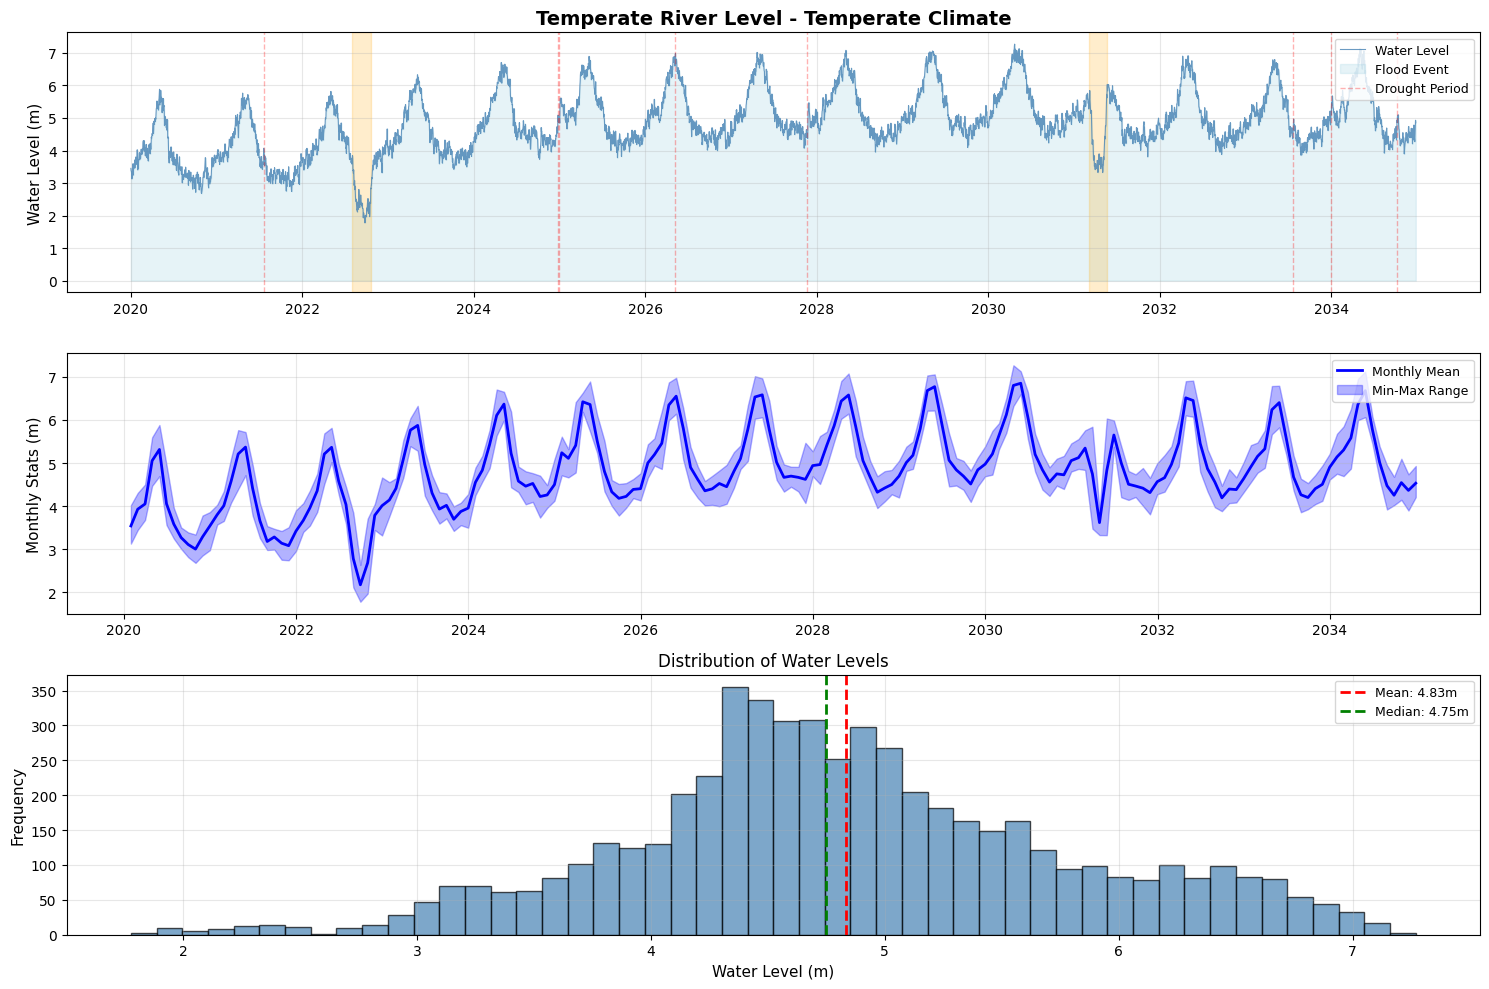

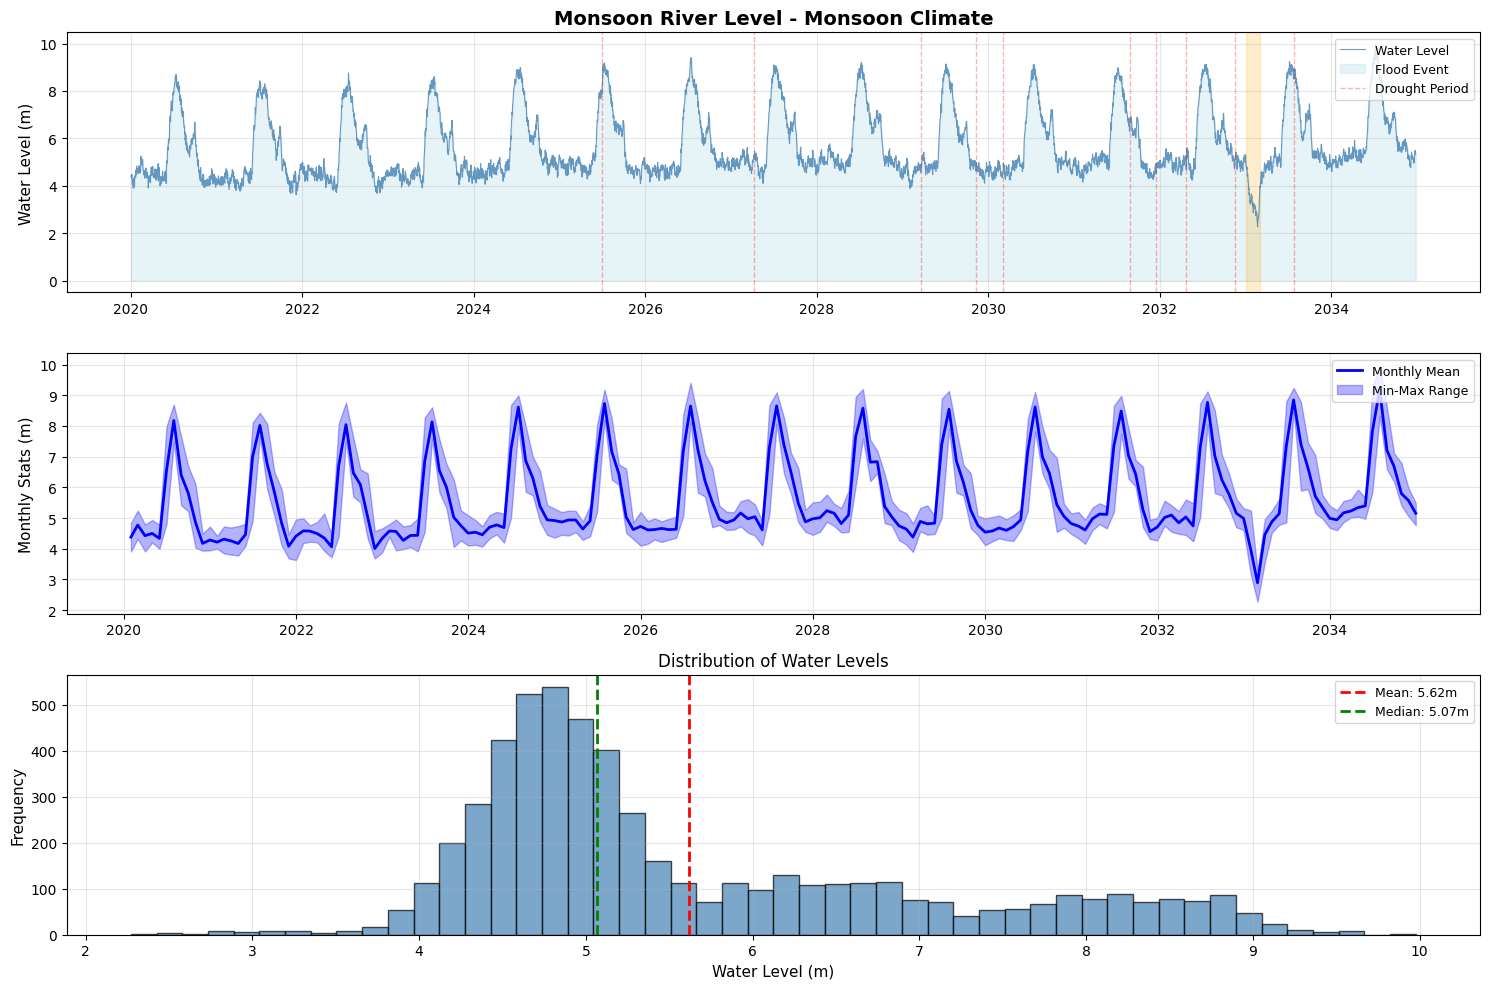

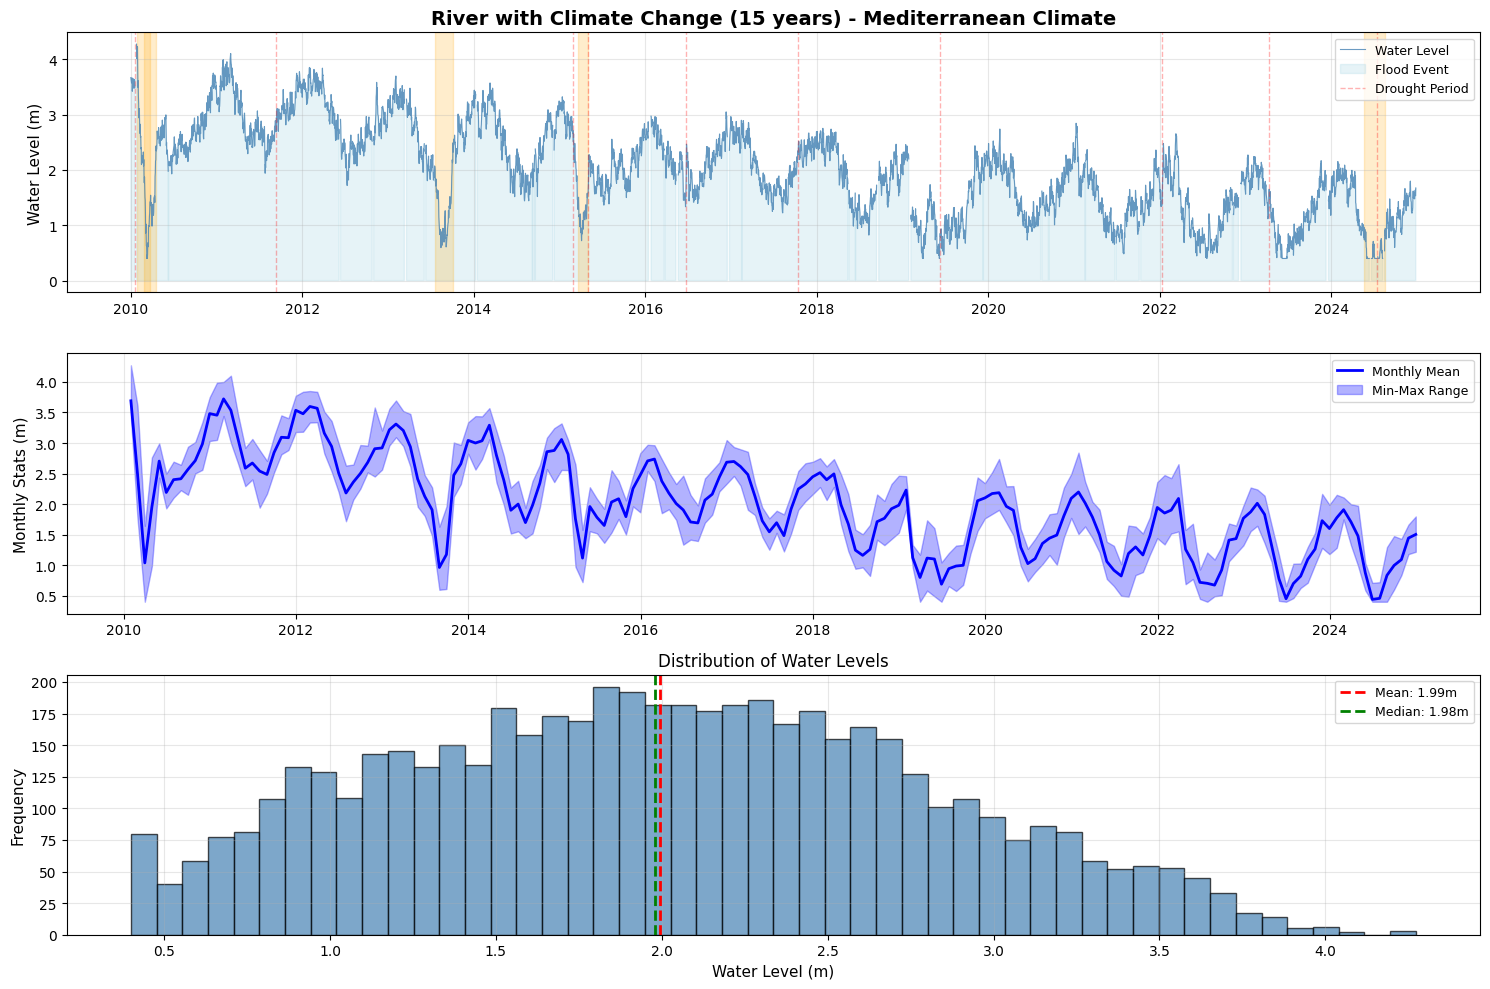

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class RiverLevelSimulator:
    """
    Simulate realistic river level time series with hydrological characteristics
    
    Key features:
    - Seasonal patterns (annual cycles, snowmelt, monsoons)
    - Autocorrelation (persistence - levels change gradually)
    - Flood events (sudden spikes)
    - Drought periods (extended lows)
    - Base flow (minimum level)
    - Climate trends (long-term changes)
    - Precipitation effects
    """
    
    def __init__(self, start_date='2020-01-01', n_days=365*3, random_state=42):
        self.start_date = pd.to_datetime(start_date)
        self.n_days = n_days
        self.random_state = random_state
        np.random.seed(random_state)
        self.dates = pd.date_range(start=self.start_date, periods=n_days, freq='D')
        
    def generate_base_flow(self, mean_level=2.0, min_level=0.5):
        """
        Generate base flow - the minimum sustained level
        
        Parameters:
        -----------
        mean_level : float
            Average base flow level (meters)
        min_level : float
            Minimum possible level (meters)
        """
        # Base flow with slight random walk
        base = np.ones(self.n_days) * mean_level
        random_walk = np.cumsum(np.random.normal(0, 0.01, self.n_days))
        base = base + random_walk
        base = np.maximum(base, min_level)  # Ensure non-negative
        return base
    
    def add_seasonal_pattern(self, base, pattern_type='temperate', amplitude=1.0):
        """
        Add seasonal variations based on climate type
        
        Parameters:
        -----------
        base : array
            Base flow to add seasonality to
        pattern_type : str
            'temperate' - single annual peak (spring snowmelt)
            'monsoon' - dramatic wet/dry seasons
            'mediterranean' - winter wet, summer dry
            'tropical' - bimodal (two rainy seasons)
        amplitude : float
            Strength of seasonal signal (meters)
        """
        t = np.arange(self.n_days)
        day_of_year = self.dates.dayofyear.values
        
        if pattern_type == 'temperate':
            # Peak in spring (day 120 ≈ late April)
            seasonal = amplitude * np.exp(-((day_of_year - 120) ** 2) / (2 * 30**2))
            seasonal += 0.3 * amplitude * np.sin(2 * np.pi * t / 365.25)
            
        elif pattern_type == 'monsoon':
            # Dramatic peak in monsoon season (June-September)
            monsoon_start = 152  # June 1
            monsoon_end = 273    # Sept 30
            seasonal = np.zeros(self.n_days)
            for i, doy in enumerate(day_of_year):
                if monsoon_start <= doy <= monsoon_end:
                    # High levels during monsoon
                    seasonal[i] = amplitude * (1 + 0.5 * np.sin(2 * np.pi * (doy - monsoon_start) / 
                                                                (monsoon_end - monsoon_start)))
                else:
                    # Low levels outside monsoon
                    seasonal[i] = 0.1 * amplitude
                    
        elif pattern_type == 'mediterranean':
            # Wet winter (Nov-Mar), dry summer (Jun-Aug)
            seasonal = amplitude * np.cos(2 * np.pi * (day_of_year - 15) / 365.25)
            seasonal = (seasonal + amplitude) / 2  # Shift to positive
            
        elif pattern_type == 'tropical':
            # Bimodal - two rainy seasons
            seasonal = amplitude * (np.sin(2 * np.pi * t / 365.25) + 
                                   0.7 * np.sin(4 * np.pi * t / 365.25 + np.pi/3))
            seasonal = (seasonal + 2*amplitude) / 3
            
        return base + seasonal
    
    def add_precipitation_events(self, series, n_events=None, intensity_range=(0.5, 3.0)):
        """
        Add random precipitation/flood events
        
        Parameters:
        -----------
        series : array
            Time series to add events to
        n_events : int
            Number of rainfall events (if None, use Poisson with lambda=n_days/30)
        intensity_range : tuple
            Min and max peak height (meters)
        """
        if n_events is None:
            # Average ~1 event per month
            n_events = np.random.poisson(self.n_days / 30)
        
        series_with_events = series.copy()
        event_dates = []
        
        for _ in range(n_events):
            # Random event location
            event_day = np.random.randint(5, self.n_days - 5)
            
            # Event characteristics
            peak_height = np.random.uniform(*intensity_range)
            duration = np.random.randint(3, 10)  # days
            
            # Create flood hydrograph (rapid rise, slower recession)
            rising_limb = int(duration * 0.3)
            falling_limb = duration - rising_limb
            
            # Rising phase (exponential)
            for i in range(rising_limb):
                if event_day + i < self.n_days:
                    factor = (i / rising_limb) ** 2
                    series_with_events[event_day + i] += peak_height * factor
            
            # Falling phase (exponential decay)
            for i in range(falling_limb):
                if event_day + rising_limb + i < self.n_days:
                    factor = np.exp(-3 * i / falling_limb)
                    series_with_events[event_day + rising_limb + i] += peak_height * factor
            
            event_dates.append(self.dates[event_day])
        
        return series_with_events, event_dates
    
    def add_drought_periods(self, series, n_droughts=None, severity_range=(0.3, 0.7)):
        """
        Add extended low-flow periods (droughts)
        
        Parameters:
        -----------
        series : array
            Time series to modify
        n_droughts : int
            Number of drought periods (if None, use n_years)
        severity_range : tuple
            Fraction to multiply flow by (0.3 = 70% reduction)
        """
        n_years = self.n_days / 365
        if n_droughts is None:
            n_droughts = int(n_years)
        
        series_with_droughts = series.copy()
        drought_periods = []
        
        for _ in range(n_droughts):
            # Random drought location and duration
            drought_start = np.random.randint(0, self.n_days - 60)
            drought_duration = np.random.randint(30, 120)  # 1-4 months
            drought_end = min(drought_start + drought_duration, self.n_days)
            
            # Severity (how much to reduce flow)
            severity = np.random.uniform(*severity_range)
            
            # Gradual onset and recovery
            for i in range(drought_start, drought_end):
                # Smooth transition in/out
                progress = (i - drought_start) / drought_duration
                if progress < 0.2:  # Onset
                    factor = 1 - (progress / 0.2) * (1 - severity)
                elif progress > 0.8:  # Recovery
                    factor = severity + ((progress - 0.8) / 0.2) * (1 - severity)
                else:  # Full drought
                    factor = severity
                
                series_with_droughts[i] *= factor
            
            drought_periods.append((self.dates[drought_start], self.dates[drought_end-1]))
        
        return series_with_droughts, drought_periods
    
    def add_trend(self, series, trend_type='linear', magnitude=0.0005):
        """
        Add long-term trend (e.g., climate change, land use changes)
        
        Parameters:
        -----------
        series : array
            Time series to add trend to
        trend_type : str
            'linear', 'increasing', 'decreasing', or 'none'
        magnitude : float
            Daily rate of change (meters/day)
        """
        t = np.arange(self.n_days)
        
        if trend_type == 'linear' or trend_type == 'increasing':
            trend = magnitude * t
        elif trend_type == 'decreasing':
            trend = -magnitude * t
        else:
            trend = np.zeros(self.n_days)
        
        return series + trend
    
    def add_autocorrelation(self, series, ar_coef=0.7):
        """
        Add persistence/memory to the series (yesterday affects today)
        
        Parameters:
        -----------
        series : array
            Time series
        ar_coef : float
            Autocorrelation coefficient (0.7-0.9 typical for rivers)
        """
        noise = np.random.normal(0, 0.1, self.n_days)
        ar_series = series.copy()
        
        for i in range(1, self.n_days):
            ar_series[i] = ar_coef * ar_series[i-1] + (1-ar_coef) * series[i] + noise[i]
        
        return ar_series
    
    def add_measurement_noise(self, series, noise_std=0.05):
        """Add measurement error (sensor noise, human error)"""
        noise = np.random.normal(0, noise_std, self.n_days)
        return series + noise
    
    def add_missing_data(self, series, missing_fraction=0.02, cluster=True):
        """
        Add missing data (sensor failures)
        
        Parameters:
        -----------
        series : array
            Time series
        missing_fraction : float
            Fraction of missing data
        cluster : bool
            If True, missing data occurs in clusters (sensor outages)
        """
        series_with_gaps = series.copy()
        
        if cluster:
            # Missing data in clusters (outages)
            n_outages = int((self.n_days * missing_fraction) / 5)
            for _ in range(n_outages):
                outage_start = np.random.randint(0, self.n_days - 10)
                outage_duration = np.random.randint(1, 10)
                outage_end = min(outage_start + outage_duration, self.n_days)
                series_with_gaps[outage_start:outage_end] = np.nan
        else:
            # Random missing points
            n_missing = int(self.n_days * missing_fraction)
            missing_idx = np.random.choice(self.n_days, n_missing, replace=False)
            series_with_gaps[missing_idx] = np.nan
        
        return series_with_gaps
    
    def generate_realistic_river(self, 
                                 mean_level=2.0,
                                 min_level=0.5,
                                 climate='temperate',
                                 seasonal_amplitude=1.0,
                                 n_flood_events=None,
                                 n_droughts=None,
                                 trend='none',
                                 trend_magnitude=0.0,
                                 autocorrelation=0.8,
                                 measurement_noise=0.05,
                                 missing_data_fraction=0.0):
        """
        Generate a complete realistic river level time series
        
        Parameters:
        -----------
        mean_level : float
            Average water level (meters)
        min_level : float
            Minimum level (meters)
        climate : str
            Climate pattern: 'temperate', 'monsoon', 'mediterranean', 'tropical'
        seasonal_amplitude : float
            Strength of seasonal variation (meters)
        n_flood_events : int
            Number of flood events (None = auto)
        n_droughts : int
            Number of drought periods (None = auto)
        trend : str
            Long-term trend: 'none', 'increasing', 'decreasing'
        trend_magnitude : float
            Daily trend rate (meters/day)
        autocorrelation : float
            Persistence coefficient (0.7-0.95 for rivers)
        measurement_noise : float
            Sensor noise std dev (meters)
        missing_data_fraction : float
            Fraction of missing data (0-1)
        
        Returns:
        --------
        pd.DataFrame with dates and levels, plus metadata
        """
        # Step 1: Base flow
        level = self.generate_base_flow(mean_level, min_level)
        
        # Step 2: Seasonal pattern
        level = self.add_seasonal_pattern(level, climate, seasonal_amplitude)
        
        # Step 3: Trend
        level = self.add_trend(level, trend, trend_magnitude)
        
        # Step 4: Flood events
        level, flood_dates = self.add_precipitation_events(level, n_flood_events)
        
        # Step 5: Droughts
        level, drought_periods = self.add_drought_periods(level, n_droughts)
        
        # Step 6: Autocorrelation (persistence)
        level = self.add_autocorrelation(level, autocorrelation)
        
        # Step 7: Measurement noise
        level = self.add_measurement_noise(level, measurement_noise)
        
        # Ensure non-negative
        level = np.maximum(level, min_level * 0.5)
        
        # Step 8: Missing data
        if missing_data_fraction > 0:
            level = self.add_missing_data(level, missing_data_fraction)
        
        # Create DataFrame
        df = pd.DataFrame({
            'date': self.dates,
            'level_m': level
        })
        
        # Metadata
        metadata = {
            'mean_level': mean_level,
            'climate': climate,
            'n_flood_events': len(flood_dates),
            'flood_dates': flood_dates,
            'n_droughts': len(drought_periods),
            'drought_periods': drought_periods,
            'trend': trend,
            'autocorrelation': autocorrelation
        }
        
        return df, metadata
    
    def plot_river_series(self, df, metadata, title="Simulated River Level"):
        """Create comprehensive visualization of river level time series"""
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        # Main time series
        ax = axes[0]
        ax.plot(df['date'], df['level_m'], linewidth=0.8, color='steelblue', alpha=0.8)
        ax.fill_between(df['date'], 0, df['level_m'], alpha=0.3, color='lightblue')
        
        # Mark flood events
        if metadata['flood_dates']:
            for flood_date in metadata['flood_dates'][:10]:  # Show first 10
                ax.axvline(flood_date, color='red', alpha=0.3, linestyle='--', linewidth=1)
        
        # Mark drought periods
        if metadata['drought_periods']:
            for drought_start, drought_end in metadata['drought_periods'][:5]:
                ax.axvspan(drought_start, drought_end, alpha=0.2, color='orange')
        
        ax.set_title(f"{title} - {metadata['climate'].title()} Climate", fontsize=14, fontweight='bold')
        ax.set_ylabel('Water Level (m)', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(['Water Level', 'Flood Event', 'Drought Period'], 
                 loc='upper right', fontsize=9)
        
        # Monthly statistics
        ax = axes[1]
        df_monthly = df.set_index('date').resample('M').agg({
            'level_m': ['mean', 'min', 'max']
        })
        df_monthly.columns = ['mean', 'min', 'max']
        
        ax.plot(df_monthly.index, df_monthly['mean'], 'b-', linewidth=2, label='Monthly Mean')
        ax.fill_between(df_monthly.index, df_monthly['min'], df_monthly['max'], 
                       alpha=0.3, color='blue', label='Min-Max Range')
        ax.set_ylabel('Monthly Stats (m)', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)
        
        # Distribution
        ax = axes[2]
        valid_data = df['level_m'].dropna()
        ax.hist(valid_data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax.axvline(valid_data.mean(), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {valid_data.mean():.2f}m')
        ax.axvline(valid_data.median(), color='green', linestyle='--', linewidth=2,
                  label=f'Median: {valid_data.median():.2f}m')
        ax.set_xlabel('Water Level (m)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title('Distribution of Water Levels', fontsize=12)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


# Example usage and scenarios
print("="*70)
print(" RIVER LEVEL SIMULATOR - DEMONSTRATION")
print("="*70)

# Scenario 1: Temperate river with snowmelt
print("\n1. TEMPERATE RIVER (e.g., Rhine, Columbia)")
print("-" * 70)
sim = RiverLevelSimulator(start_date='2020-01-01', n_days=365*15, random_state=42)

df1, meta1 = sim.generate_realistic_river(
    mean_level=3.5,
    min_level=1.0,
    climate='temperate',
    seasonal_amplitude=1.5,
    n_flood_events=8,
    n_droughts=2,
    trend='increasing',
    trend_magnitude=0.0002,  # Slight increase over time
    autocorrelation=0.85,
    measurement_noise=0.08
)

print(f"Generated {len(df1)} days of data")
print(f"Mean level: {df1['level_m'].mean():.2f}m")
print(f"Std dev: {df1['level_m'].std():.2f}m")
print(f"Min: {df1['level_m'].min():.2f}m, Max: {df1['level_m'].max():.2f}m")
print(f"Flood events: {meta1['n_flood_events']}")
print(f"Drought periods: {meta1['n_droughts']}")

fig1 = sim.plot_river_series(df1, meta1, "Temperate River Level")
plt.savefig('river_temperate.png', dpi=300, bbox_inches='tight')
df1.to_csv('river_temperate.csv', index=False)

# Scenario 2: Monsoon river
print("\n2. MONSOON RIVER (e.g., Ganges, Mekong)")
print("-" * 70)
sim2 = RiverLevelSimulator(start_date='2020-01-01', n_days=365*15, random_state=43)

df2, meta2 = sim2.generate_realistic_river(
    mean_level=4.0,
    min_level=0.5,
    climate='monsoon',
    seasonal_amplitude=3.0,  # Dramatic seasonal variation
    n_flood_events=15,
    n_droughts=1,
    trend='none',
    autocorrelation=0.90,  # High persistence
    measurement_noise=0.10
)

print(f"Generated {len(df2)} days of data")
print(f"Mean level: {df2['level_m'].mean():.2f}m")
print(f"Std dev: {df2['level_m'].std():.2f}m")
print(f"Min: {df2['level_m'].min():.2f}m, Max: {df2['level_m'].max():.2f}m")

fig2 = sim2.plot_river_series(df2, meta2, "Monsoon River Level")
plt.savefig('river_monsoon.png', dpi=300, bbox_inches='tight')
df2.to_csv('river_monsoon.csv', index=False)

# Scenario 3: River with climate change trend
print("\n3. RIVER WITH CLIMATE CHANGE IMPACT")
print("-" * 70)
sim3 = RiverLevelSimulator(start_date='2010-01-01', n_days=365*15, random_state=44)

df3, meta3 = sim3.generate_realistic_river(
    mean_level=2.5,
    min_level=0.8,
    climate='mediterranean',
    seasonal_amplitude=1.2,
    n_flood_events=30,
    n_droughts=8,
    trend='decreasing',  # Declining water levels
    trend_magnitude=0.0003,
    autocorrelation=0.88,
    measurement_noise=0.06,
    missing_data_fraction=0.03  # 3% missing data
)

print(f"Generated {len(df3)} days of data ({len(df3)/365:.1f} years)")
print(f"Mean level: {df3['level_m'].mean():.2f}m")
print(f"Missing data: {df3['level_m'].isna().sum()} days ({df3['level_m'].isna().mean()*100:.1f}%)")
print(f"Trend: {meta3['trend']}")

fig3 = sim3.plot_river_series(df3, meta3, "River with Climate Change (15 years)")
plt.savefig('river_climate_change.png', dpi=300, bbox_inches='tight')
df3.to_csv('river_climate_change.csv', index=False)

print("\n" + "="*70)
print(" SUMMARY STATISTICS")
print("="*70)

summary = pd.DataFrame({
    'River Type': ['Temperate', 'Monsoon', 'Climate Change'],
    'Mean (m)': [df1['level_m'].mean(), df2['level_m'].mean(), df3['level_m'].mean()],
    'Std Dev (m)': [df1['level_m'].std(), df2['level_m'].std(), df3['level_m'].std()],
    'Max (m)': [df1['level_m'].max(), df2['level_m'].max(), df3['level_m'].max()],
    'CV': [df1['level_m'].std()/df1['level_m'].mean(), 
           df2['level_m'].std()/df2['level_m'].mean(),
           df3['level_m'].std()/df3['level_m'].mean()]
})

print("\n" + summary.to_string(index=False))
print("\nCV = Coefficient of Variation (higher = more variable)")

print("\n" + "="*70)
print(" FILES SAVED")
print("="*70)
print("✓ river_temperate.png & .csv")
print("✓ river_monsoon.png & .csv")
print("✓ river_climate_change.png & .csv")
print("\nAll scenarios generated successfully!")